In [79]:
import imagej
import os
import scyjava as sj
from scyjava import jimport
import random
import sys
sj.config.add_options('-Xmx12g')

os.environ["JAVA_HOME"] = "/Users/nelsschimek/mambaforge/envs/i2k-2022-pyimagej/"

In [2]:
# initialize ImageJ
ij = imagej.init('/Applications/Fiji.app/')
print(f"ImageJ version: {ij.getVersion()}")

ImageJ version: 2.9.0/1.53t


In [3]:
Runtime = jimport('java.lang.Runtime')

In [8]:
print(Runtime.getRuntime().maxMemory() // (2**20), " MB available to java")

5461  MB available to java


In [85]:
image_path = "/Users/nelsschimek/Documents/nancelab/diff_classifier/notebooks/development/MPT_Data/TIFs/P10F_NT_10DIV_40nm_slice_2_midbrain_vid_2.tif"
image = ij.io().open(image_path)

In [154]:
def dump_info(image):
    """A handy function to print details of an image object."""
    name = image.name if hasattr(image, 'name') else None # xarray
    if name is None and hasattr(image, 'getName'): name = image.getName() # Dataset
    if name is None and hasattr(image, 'getTitle'): name = image.getTitle() # ImagePlus
    print(f" name: {name or 'N/A'}")
    print(f" type: {type(image)}")
    print(f"dtype: {image.dtype if hasattr(image, 'dtype') else 'N/A'}")
    print(f"shape: {image.shape}")
    print(f" dims: {image.dims if hasattr(image, 'dims') else 'N/A'}")

if not 'image' in locals(): print("I cannot find any variable called embryo. Did you write `embryo = ...` above?")
elif str(type(image)) != "<java class 'net.imagej.DefaultDataset'>": print("The embryo variable does not contain an ImageJ2 Dataset. Did you use the `ij.io().open` function?")
else: dump_info(image)

 name: P10F_NT_10DIV_40nm_slice_2_midbrain_vid_2.tif
 type: <java class 'net.imagej.DefaultDataset'>
dtype: <java class 'net.imglib2.type.numeric.integer.UnsignedShortType'>
shape: (2048, 2044, 651)
 dims: ('X', 'Y', 'Unknown')


In [17]:
image[:,:,0]

<java object 'net.imglib2.view.IntervalView'>

In [18]:
ij.py.show(image)

In [9]:
import skimage
mitepy = skimage.data.human_mitosis()

Operating in headless mode - the original ImageJ will have limited functionality.


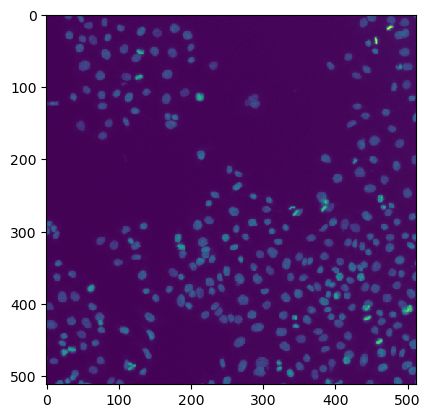

In [10]:
miteimp = ij.py.to_imageplus(mitepy)
ij.py.show(miteimp)

In [11]:
args = {"sigma": 10}
ij.py.run_plugin("Gaussian Blur...", args, imp=miteimp)
ij.py.sync_image(miteimp)


Operating in headless mode - the IJ class will not be fully functional.


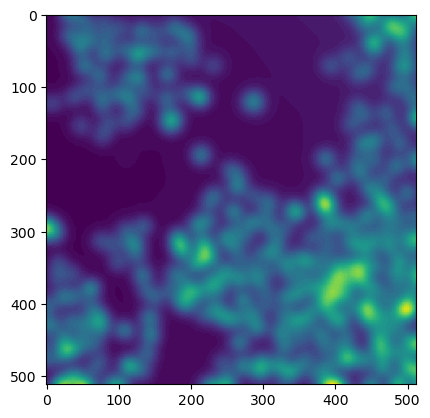

In [12]:
ij.py.show(mitepy)

In [ ]:
args = {}

In [23]:
results = ij.py.run_plugin("TrackMate", args, mitepy)

The following parameters are unkown and were ignored:

  sigma
Please open an image before running TrackMate.


[java.lang.Enum.toString] The following parameters are unkown and were ignored:
[java.lang.Enum.toString] 
[java.lang.Enum.toString]   sigma[java.lang.Enum.toString] 
[java.lang.Enum.toString] Please open an image before running TrackMate.[java.lang.Enum.toString] 


In [22]:
results

In [141]:
Model = sj.jimport('fiji.plugin.trackmate.Model')
Settings = sj.jimport('fiji.plugin.trackmate.Settings')
TrackMate = sj.jimport('fiji.plugin.trackmate.TrackMate')
FeatureFilter = sj.jimport('fiji.plugin.trackmate.features.FeatureFilter')
LAPUtils =  sj.jimport('fiji.plugin.trackmate.tracking.jaqaman.LAPUtils')
SelectionModel = sj.jimport('fiji.plugin.trackmate.SelectionModel')
Logger = sj.jimport('fiji.plugin.trackmate.Logger')

DisplaySettingsIO = sj.jimport('fiji.plugin.trackmate.gui.displaysettings.DisplaySettingsIO')
HyperStackDisplayer = sj.jimport('fiji.plugin.trackmate.visualization.hyperstack.HyperStackDisplayer')

In [66]:
LogDetectorFactory = sj.jimport('fiji.plugin.trackmate.detection.LogDetectorFactory')

In [94]:
SparseLAPTrackerFactory = sj.jimport('fiji.plugin.trackmate.tracking.jaqaman.SparseLAPTrackerFactory')

In [71]:
model = Model()

In [130]:
model.setLogger(Logger.IJ_LOGGER)

In [131]:

#im = ij.io().open('https://fiji.sc/samples/FakeTracks.tif')


In [146]:
imp = ij.py.to_imageplus(image)

In [147]:
settings = Settings(imp)

In [148]:
settings.detectorFactory = LogDetectorFactory()
settings.detectorSettings = {
    'DO_SUBPIXEL_LOCALIZATION' : True,
    'RADIUS' : 2.5,
    'TARGET_CHANNEL' : ij.py.to_java(1),
    'THRESHOLD' : 0.,
    'DO_MEDIAN_FILTERING' : False,
}  
filter1 = FeatureFilter('QUALITY', 30, True)
settings.addSpotFilter(filter1)


In [149]:
# Configure tracker
settings.trackerFactory = SparseLAPTrackerFactory()
settings.trackerSettings = LAPUtils.getDefaultSegmentSettingsMap()
settings.trackerSettings['LINKING_MAX_DISTANCE'] = 10.0
settings.trackerSettings['GAP_CLOSING_MAX_DISTANCE'] = 10.0
settings.trackerSettings['MAX_FRAME_GAP'] = ij.py.to_java(3)

In [150]:
trackmate = TrackMate(model, settings)

In [156]:
trackmate.execDetection()

Starting detection process using 8 threads.



[java.lang.Enum.toString] Starting detection process using 8 threads.
[java.lang.Enum.toString] 


In [152]:
ok = trackmate.checkInput()
if not ok:
    sys.exit(str(trackmate.getErrorMessage()))

In [153]:
from scyjava import jimport
Runtime = jimport('java.lang.Runtime')
def java_mem():
    rt = Runtime.getRuntime()
    mem_max = rt.maxMemory()
    mem_used = rt.totalMemory() - rt.freeMemory()
    return '{} of {} MB ({}%)'.format(int(mem_used)/2**20, int(mem_max/2**20), int(100*mem_used/mem_max))

java_mem()

'1313.4216918945312 of 5461 MB (24%)'

In [151]:


ok = trackmate.process()
if not ok:
    sys.exit(str(trackmate.getErrorMessage()))

Starting detection process using 8 threads.



[java.lang.Enum.toString] Starting detection process using 8 threads.
[java.lang.Enum.toString] 


java.lang.OutOfMemoryError: java.lang.OutOfMemoryError: GC overhead limit exceeded

In [139]:
model.getLogger().log('Found ' + str(model.getTrackModel().nTracks(True)) + ' tracks.')


Found 9 tracks.


[java.lang.Enum.toString] Found 9 tracks.[java.lang.Enum.toString] 


In [143]:
# A selection.
sm = SelectionModel( model )

# Read the default display settings.
ds = DisplaySettingsIO.readUserDefault()

# The viewer.
displayer =  HyperStackDisplayer( model, sm, imp, ds ) 
#displayer.render()

# The feature model, that stores edge and track features.
fm = model.getFeatureModel()

In [144]:
# Iterate over all the tracks that are visible.
for id in model.getTrackModel().trackIDs(True):

    # Fetch the track feature from the feature model.
    v = fm.getTrackFeature(id, 'TRACK_MEAN_SPEED')
    model.getLogger().log('')
    model.getLogger().log('Track ' + str(id) + ': mean velocity = ' + str(v) + ' ' + model.getSpaceUnits() + '/' + model.getTimeUnits())

	# Get all the spots of the current track.
    track = model.getTrackModel().trackSpots(id)
    for spot in track:
        sid = spot.ID()
        # Fetch spot features directly from spot.
        # Note that for spots the feature values are not stored in the FeatureModel
        # object, but in the Spot object directly. This is an exception; for tracks
        # and edges, you have to query the feature model.
        x=spot.getFeature('POSITION_X')
        y=spot.getFeature('POSITION_Y')
        t=spot.getFeature('FRAME')
        q=spot.getFeature('QUALITY')
        snr=spot.getFeature('SNR_CH1')
        mean=spot.getFeature('MEAN_INTENSITY_CH1')
        model.getLogger().log('\tspot ID = ' + str(sid) + ': x='+str(x)+', y='+str(y)+', t='+str(t)+', q='+str(q) + ', snr='+str(snr) + ', mean = ' + str(mean))

[java.lang.Enum.toString] 


TypeError: can only concatenate str (not "java.lang.String") to str

In [145]:
fm

<java object 'fiji.plugin.trackmate.FeatureModel'>